### Single-input Network - PyTorch

Predicts the action given a single observation (checks whether the Dataset is 'difficult' to learn)

### Imports

In [1]:
"""
Imports external and own libraries
"""

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

### Preprocess data

In [12]:
# split data
train_data, test_data = preprocess.split_data(random_data, 0.8)

# preprocess trainingset
oracle_train_data = preprocess.ObtainDataset(train_data, "observations", "actions")
oracle_test_data = preprocess.ObtainDataset(test_data, "observations", "actions")

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(
    oracle_train_data, batch_size=batch_size, shuffle=True
)
dataset_loader_test_data = DataLoader(
    oracle_test_data, batch_size=batch_size, shuffle=True
)

### Visualize a batch of data (size 64)

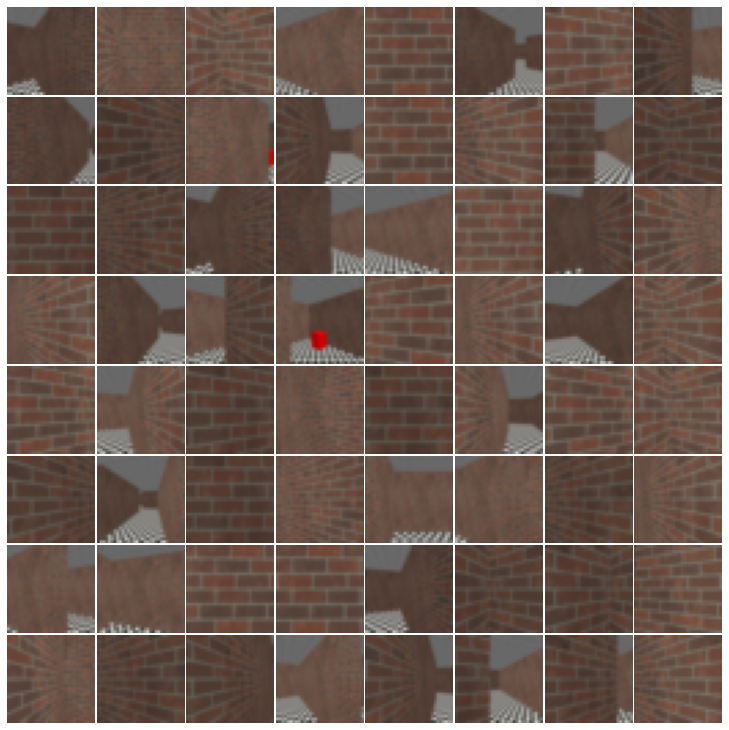

In [13]:
dataiter = iter(dataset_loader_train_data)
images, labels = dataiter.next()
plot.plot_64_observations(images)

### Initialize the model

In [5]:
forward = nets.Forward(64)
summary(forward, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 64]           5,440
Total params: 66,596
Trainable params: 66,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


### Train model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    forward.parameters(), lr=0.001
)  # , momentum=0.9) # for small one 0.01 works well

episodes = 50
forward, train_loss, test_loss, train_acc, test_acc = train.train_Feedforward(
    dataset_loader_train_data,
    dataset_loader_test_data,
    forward,
    criterion,
    optimizer,
    episodes,
)

Progress:   0%|          | 0/50 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 3.986, Train Acc: 32.32 %,  Test Loss: 3.437, Test Acc: 85.77 %,
Epoch: 11, Train Loss: 0.5961, Train Acc: 82.11 %,  Test Loss: 0.5154, Test Acc: 85.77 %,
Epoch: 21, Train Loss: 0.6037, Train Acc: 82.11 %,  Test Loss: 0.5079, Test Acc: 85.77 %,
Epoch: 31, Train Loss: 0.5927, Train Acc: 82.11 %,  Test Loss: 0.5121, Test Acc: 85.77 %,
Epoch: 41, Train Loss: 0.5915, Train Acc: 82.11 %,  Test Loss: 0.5025, Test Acc: 85.77 %,
Finished Training


### Plot loss and accuracy curves for training and test set

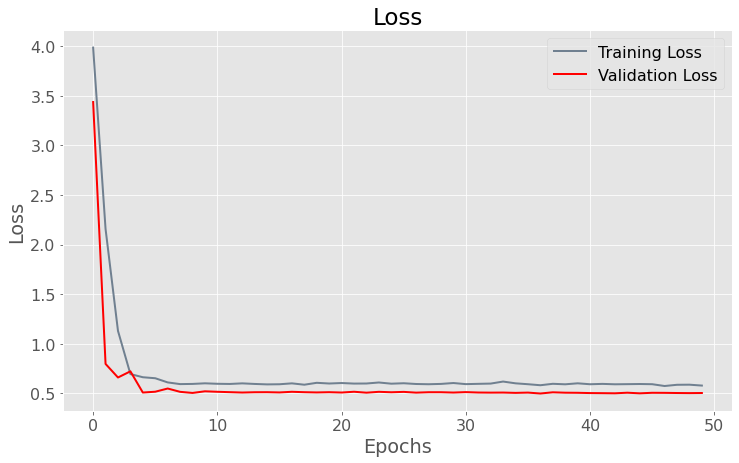

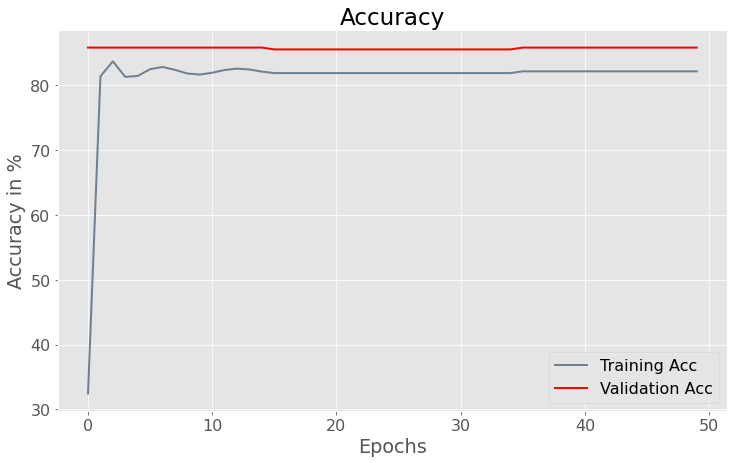

In [7]:
plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)

### Plot example classifications and plot confusion matrix

GroundTruth:  walk forwards, turn right, walk forwards, walk forwards, walk forwards, walk forwards, turn left, walk forwards
Predicted:  walk forwards, walk forwards, walk forwards, walk forwards, walk forwards, walk forwards, walk forwards, walk forwards 



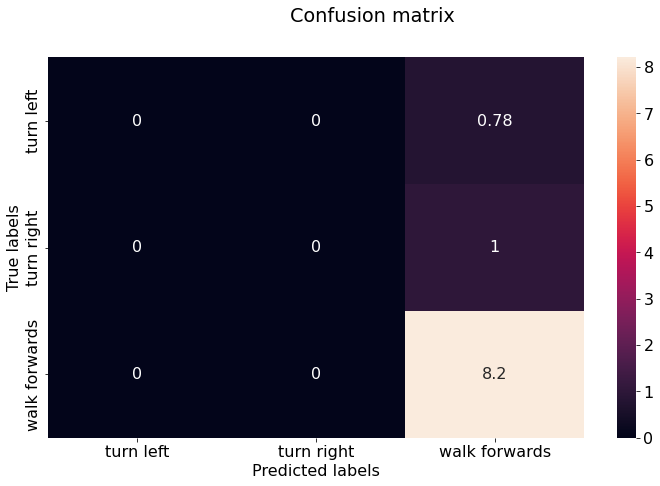

In [8]:
plot.show_example_classificataions(dataset_loader_train_data, forward, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, forward)

### Save and load models

In [ ]:
# Save
torch.save(model, "models/Feedforward_overfitted.pt")

# Load
# model = torch.load('models/Feedforward.pt')
# model.eval()